## Приложение доставки

#### Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [65]:
#Импорт необходимых библиотек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import requests 
from urllib.parse import urlencode

### Прочитаем файлы. 


In [66]:
ab_users_data  = pd.read_csv('ab_users_data.csv')
ab_orders = pd.read_csv('ab_orders.csv')
ab_products = pd.read_csv('ab_products.csv')

In [67]:
ab_users_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [68]:
#Нужно конверитировать в дату колнки  time и date
ab_users_data['time'] = pd.to_datetime(ab_users_data['time'])
ab_users_data['date'] = pd.to_datetime(ab_users_data['date'])

In [69]:
#Нужно конверитировать в дату колнку  creation_time
ab_orders['creation_time'] = pd.to_datetime(ab_orders['creation_time'])

**Выделю для себя:** 

1. Контрольная группа - я буду так называть группу, которая пользуется приложением со старым алгоритмом (**group == 0**)
2. Тестовая группа - группа, которая пользуется приложением с новым алгоритмом (**group == 1**)

##### Варианты метрик:

1. Количество отмененных заказов
2. Средний чек
3. Количество активных пользователей(DAU)
4. Среднее кол-во товаров в заказах
5. Кол-во созданных заказов

In [70]:
#Количество наблюдений в группах
ab_users_data['group'].value_counts()

group
1    2646
0    1691
Name: count, dtype: int64

## 1. Метрика - количество отмененных заказов

In [71]:
#Выделю в отдельный дф кол-во отмененных заказов в тестовой и контрольной группе 
cancel_order_control = ab_users_data.query('action=="cancel_order" and group==0') \
        .groupby('date',as_index=False).agg({'order_id':'nunique'}).rename(columns={'order_id':'orders_control'})

cancel_order_test = ab_users_data.query('action=="cancel_order" and group==1') \
        .groupby('date',as_index=False).agg({'order_id':'nunique'}).rename(columns={'order_id':'orders_test'})

##### Визуализация метрики "Динамика отмененных заказов"

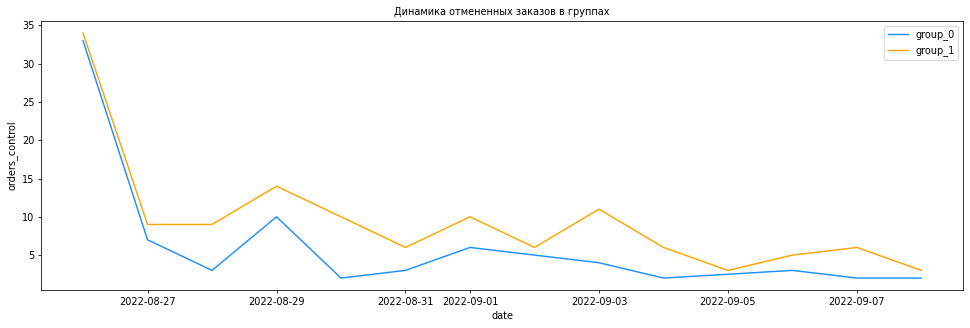

In [72]:
plt.figure(figsize=(17,5), dpi= 70)
sns.lineplot(data=cancel_order_control,x='date',y='orders_control',color="dodgerblue",label="group_0")
sns.lineplot(data=cancel_order_test,x='date',y='orders_test',color="orange",label="group_1")

plt.title('Динамика отмененных заказов в группах', fontsize=10)
plt.legend()
plt.show()

##### Визуализация распределения отмененных заказов в группах

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1472629564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cancel_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1472629564.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

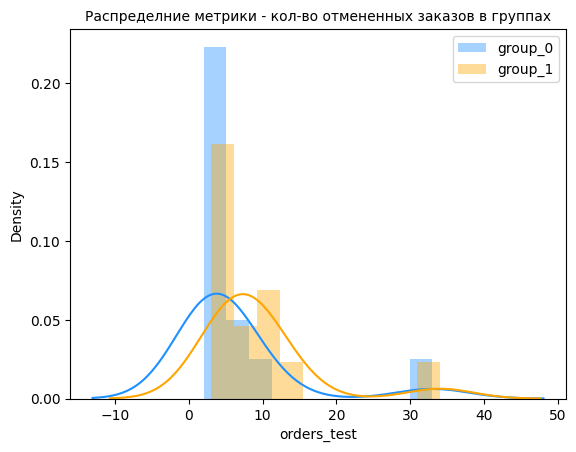

In [73]:
#Распределение метрики отмененных заказов в группах

sns.distplot(cancel_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
sns.distplot(cancel_order_test.orders_test, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние метрики - кол-во отмененных заказов в группах', fontsize=10)
plt.legend()
plt.show()

Получается распределние метрики отмененных заказов в обоих группах имеет выброс, не похоже на нормальное. Можно избавиться от этого выброса, взять данные без этих выборосов.

**Выбросы**. В контрольной группе(0) у нас есть выброс за 2022-08-26 (33 отмененных заказа). В тестовой группе(1) также за 2022-08-26	(34 отмененных заказа). 

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1257002653.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cancel_order_control.query('date !="2022-08-26"').orders_control,color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1257002653.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gi

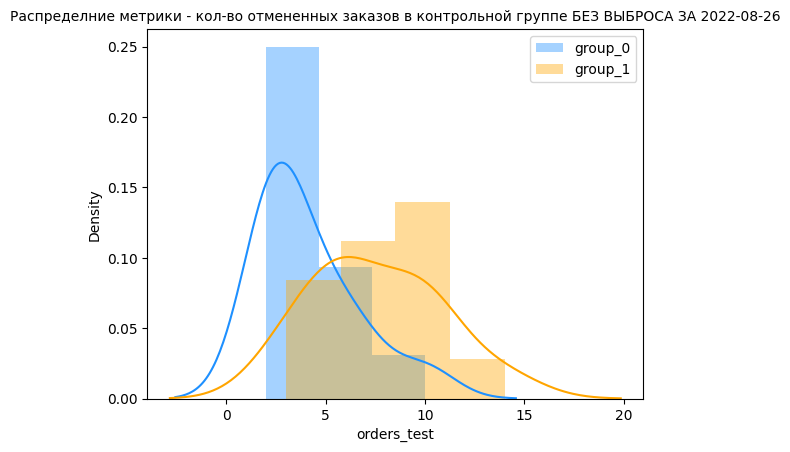

In [74]:
#Посмотрю на распределение без выбросов

sns.distplot(cancel_order_control.query('date !="2022-08-26"').orders_control,color="dodgerblue", label="group_0",kde=True)
sns.distplot(cancel_order_test.query('date !="2022-08-26"').orders_test, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние метрики - кол-во отмененных заказов в контрольной группе БЕЗ ВЫБРОСА ЗА 2022-08-26', fontsize=10)
plt.legend()
plt.show()

In [75]:
#Среднее кол-во отмененных заказов в  группах

print(f'Среднее кол-во отмененных заказов в контрольной группе(0): {round(cancel_order_control.orders_control.mean(),2)}')
print()
print(f'Среднее кол-во отмененных заказов в тестовой группе(1): {round(cancel_order_test.orders_test.mean(),2)}')

Среднее кол-во отмененных заказов в контрольной группе(0): 6.31

Среднее кол-во отмененных заказов в тестовой группе(1): 9.43


____
#### Анализ метрики - кол-во отмененных заказов - на стат значимые различия

Проведу анализ метрики количество отмененных заказов в группах. Есть ли статистически значимые различия.

In [76]:
#Среднее кол-во отмененных заказов в группах

print(f'Среднее кол-во отмененных заказов в контрольной группе(0): {round(cancel_order_control.orders_control.mean(),2)}')
print()
print(f'Среднее кол-во отмененных заказов в тестовой группе(1): {round(cancel_order_test.orders_test.mean(),2)}')

Среднее кол-во отмененных заказов в контрольной группе(0): 6.31

Среднее кол-во отмененных заказов в тестовой группе(1): 9.43


In [77]:
#Медианное значение отмененных заказов в группах

print(f'Медианное значение кол-во отмененных заказов в КОНТРОЛЬНОЙ ГРУППЕ {round(cancel_order_control.orders_control.median(),2)}')
print()
print(f'Медианное значение кол-во отмененных заказов в ТЕСТОВОЙ ГРУППЕ {round(cancel_order_test.orders_test.median(),2)}')

Медианное значение кол-во отмененных заказов в КОНТРОЛЬНОЙ ГРУППЕ 3.0

Медианное значение кол-во отмененных заказов в ТЕСТОВОЙ ГРУППЕ 7.5


Получается, что среднее значение и медианное значение кол-ва отмененных заказов в группе с новым алгоритмом больше, чем в группе со старым алгоритмом. Нужно теперь понять эти различия статистически значимы или нет.

Как я уже ранее посмотрела, распределение метрики отмененных заказов в обоих группах будет похоже на нормальное,если смотреть без одной даты с выбросом(за 2022-08-26). Проверю эту нормальность с помощью теста. 

#### Сформулирую гипотезы, которые буду проверять в этом эксперименте
---
**1. Нулевая гипотеза (H0): Разницы между средним значением кол-ва отмененных заказов в тестовой и контрольной группе нет**

**2. Альтернативная гипотеза (H1): Разница между средним значением кол-ва отмененных заказов  в тестовой и контрольной группе есть**

##### 1.Проверю выполнение условий на нормальность

--
**Контольная группа**

In [78]:
#берём данные нужной нам группы - это контрольная группа, группа со старым алгоритмом и кладём в функцию
#беру все данные
stats.normaltest(cancel_order_control.orders_control)
if stats.normaltest(cancel_order_control.orders_control)[1] < 0.05:
    print(f'Значения в выборке распределены ненормально p-value: {stats.normaltest(cancel_order_control.orders_control)[1]}')
else:
    print(f'Значения в выборке распределены нормально p-value: {stats.normaltest(cancel_order_control.orders_control)[1]}')

Значения в выборке распределены ненормально p-value: 2.7752106811374284e-07


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  k, _ = kurtosistest(a, axis)


In [79]:
#беру все без выброса 
_,p = stats.normaltest(cancel_order_control.query('date !="2022-08-26"').orders_control)

if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в выборке распределены нормально p-value:{p}')

Значения в выборке распределены ненормально p-value:0.045606613859368525


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


--**Тестовая группа**

In [80]:
#берём данные нужной нам группы - это тестовая группа, группа с новым алгоритмом и кладём в функцию
#беру все данные
_,p = stats.normaltest(cancel_order_test.orders_test)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value: {p}')
else:
    print(f'Значения в выборке распределены нормально p-value: {p}')

Значения в выборке распределены ненормально p-value: 1.8830361061410442e-06


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  k, _ = kurtosistest(a, axis)


In [82]:
#беру данные без выброса 

stat,p = stats.normaltest(cancel_order_test.query('date !="2022-08-26"').orders_test)
if p < 0.05:
    print(f'Значения в выборке распределены ненормальное p-value: {p}')
else:
    print(f'Значения в выборке распределены нормально p-value: {p}')

Значения в выборке распределены нормально p-value: 0.8105979809207297


##### Визуализация распределения данных в группах

Text(0.5, 1.0, 'Распределение данных в тестовой группе(group=1)')

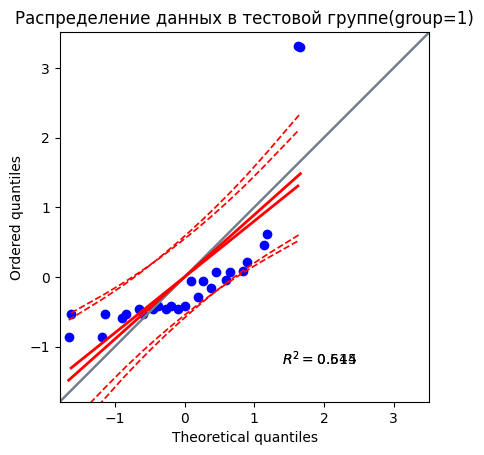

In [83]:
#Визуализация распределения без удаления выбросов
pg.qqplot(cancel_order_control.orders_control, dist='norm')
plt.title("Распределение данных в контрольной группе(group=0)")

pg.qqplot(cancel_order_test.orders_test, dist='norm')
plt.title("Распределение данных в тестовой группе(group=1)")

In [84]:
#Данные без выброса
cancel_order_test_ = cancel_order_test.query('date !="2022-08-26"').orders_test
cancel_order_control_ = cancel_order_control.query('date !="2022-08-26"').orders_control

Text(0.5, 1.0, 'Распределние метрики - кол-во отмененных заказов в тестовой группе БЕЗ ВЫБРОСА ЗА 2022-08-26')

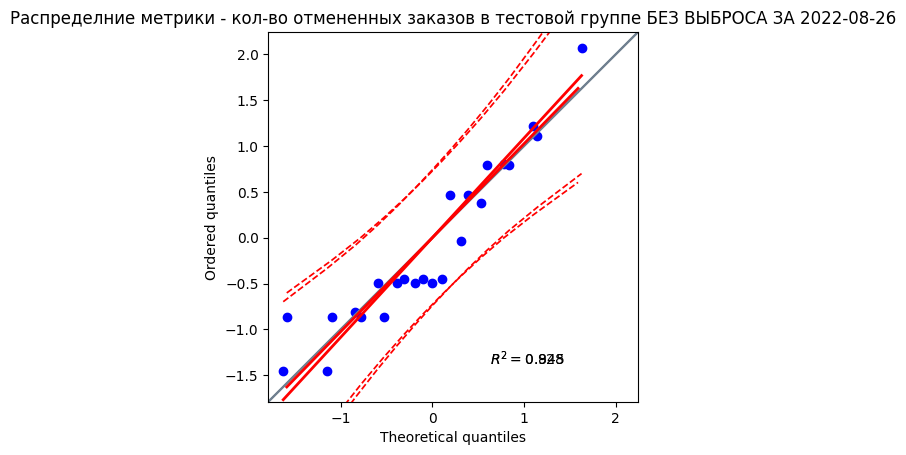

In [85]:
#Визуализация распределения данных исключая выброс за 2022-08-26

pg.qqplot(cancel_order_test_, dist='norm')
plt.title("Распределние метрики - кол-во отмененных заказов в контрольной группе БЕЗ ВЫБРОСА ЗА 2022-08-26")

pg.qqplot(cancel_order_control_, dist='norm')
plt.title("Распределние метрики - кол-во отмененных заказов в тестовой группе БЕЗ ВЫБРОСА ЗА 2022-08-26")

#### Вывод: 
Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона по функции scipy.stats.normaltest(). Этот тест показывает, что значения в тестовой группе без удаления выбросов распределены НЕНОРМАЛЬНО. Также и в контрольной группе без удаления выброса распределение не отвечает условию нормального распределения. 

Но, если мы убираем выброс за 2022-08-26. В тестовой группе становится НОРМАЛЬНЫМ, но в контрольной группе все равно значения распределены НЕНОРМАЛЬНО, но если посмотреть на саму форму распределения, то оно не настолько сильно нарушает нормальность.


Для проверки гипотез я возьму параметрический критерий для выборок без выбросов.

In [86]:
#Проверка на гомогенность дисперсий с помощью критерия Левена.

stat, p = stats.levene(cancel_order_test.orders_test,cancel_order_control.orders_control)
if p > 0.05:
    print('Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.')
else:
    print('Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается')

Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.


#### Применяю для проверки гипотез STUDENT'S T-TEST

---
**Без выбросов**

In [87]:
#Для сравнения средних в данных экспериментальных группах я использую STUDENT'S T-TEST
stat, p = stats.ttest_ind(cancel_order_test_,cancel_order_control_)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Получили статистически значимые различия. Нулевая гипотеза отклоняется')

Получили статистически значимые различия. Нулевая гипотеза отклоняется


Исходя из этого теста, получается, что в ходе эксперимента мы получили статистически значимые различия по метрике кол-во отмененных заказов.
В группе со старым алгоритмом среднее значение кол-ва отмененных заказов меньше, чем в группе с новым алгоритмом. 

In [88]:
#Общее кол-во отмененных заказов в группах
cancel_orders = ab_users_data.query('action=="cancel_order"').groupby('group',as_index=False) \
        .agg({'order_id':'count'}).rename(columns={'order_id':'orders'})

cancel_orders

,group,orders
0,0,82
1,1,132


In [89]:
#Разница в отмененных заказах между группами
diff_canc_or = cancel_orders.query('group==1').orders.values - cancel_orders.query('group==0').orders.values

print(f'В группе, которая пользуется приложением с новой системой рекомендаций кол-во отменных заказов увеличилось на {diff_canc_or[0]} заказов')

В группе, которая пользуется приложением с новой системой рекомендаций кол-во отменных заказов увеличилось на 50 заказов


## 2. Метрика - средний чек по дню 

In [90]:
#Выделю нужные колонки в отдельный дф, для работы. 
df_ab_orders = ab_orders[['order_id','product_ids']]

In [91]:
#Подготовлю данные. Нужно в дф ab_orders колонку product_ids преобразовать в отдельную строку, чтобы объединить с ab_products

#Преобразую колонку product_ids в список 
df_ab_orders['product_id'] = df_ab_orders['product_ids'].apply(lambda i: i.replace('{','').replace('}','').replace('{','').split(', '))

#Преобразую в отдельную строку, чтобы получить product_id в отдельной строке 
df_ab_orders = df_ab_orders.explode('product_id',ignore_index=False)

In [92]:
df_ab_orders = df_ab_orders.astype({'product_id':'int64'})

In [93]:
#Объединяю дф ab_orders и ab_products

purchase_orders = df_ab_orders.merge(ab_products,on='product_id')

In [94]:
#Удалю ненужные колонки
purchase_orders = purchase_orders.drop(columns='product_ids')

In [95]:
#Подсчитаю итоговую сумму заказов
total_price = purchase_orders.groupby(['order_id'],as_index=False).agg({'price':'sum'}) \
        .rename(columns={'price':'total_price'})

In [96]:
#Теперь объединю получившийся дф с данными истории заказов. 

full_orders_df = total_price.merge(ab_users_data,on='order_id')
full_orders_df.head()

,order_id,total_price,user_id,action,time,date,group
0,1255,408.7,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,1256,250.5,965,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,1257,310.2,964,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,1258,85.0,966,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,1258,85.0,966,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0


In [97]:
#Далее отфильтрую по статусу заказа. Мне нужно для подсчета среднего чека убрать отмененные заказы. 

#1 Выделила order_id отмененных заказов в отдельный лист для удобной фильтрации
list_cancel_orders = full_orders_df.query('action == "cancel_order"')['order_id'].to_list()

#2 Применила фильтр, убрала отмененные заказы
full_orders_df = full_orders_df.query('order_id not in @list_cancel_orders')

In [98]:
#Выделю тестовый и контрольный дф в отдельные дф и оставлю только созданные заказы, без отмененных

test_orders = full_orders_df.query('group == 1')
control_orders = full_orders_df.query('group == 0')

In [99]:
test_orders.head()

,order_id,total_price,user_id,action,time,date,group
1,1256,250.5,965,create_order,2022-08-26 00:02:21,2022-08-26,1
5,1259,228.0,967,create_order,2022-08-26 00:03:37,2022-08-26,1
8,1263,180.3,970,create_order,2022-08-26 00:08:22,2022-08-26,1
9,1264,310.3,971,create_order,2022-08-26 00:10:53,2022-08-26,1
11,1266,46.0,973,create_order,2022-08-26 00:12:00,2022-08-26,1


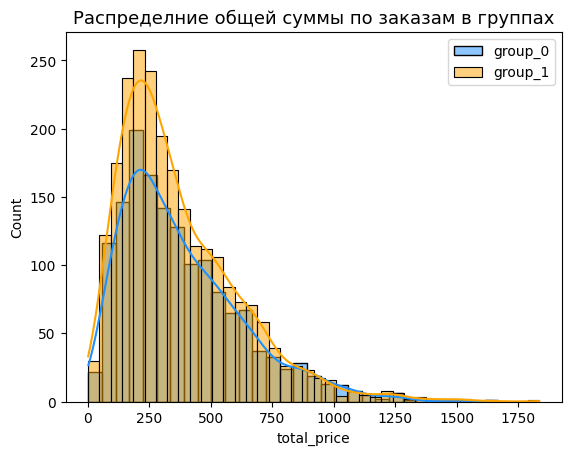

In [100]:
#Распределние total_price в группах
sns.histplot(full_orders_df.query('group == 0').total_price, color="dodgerblue", label="group_0",kde=True)
sns.histplot(full_orders_df.query('group == 1').total_price, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние общей суммы по заказам в группах', fontsize=13)
plt.legend()
plt.show()

In [101]:
full_orders_df.query('group == 1').total_price.mean()

368.86162888329136

In [102]:
full_orders_df.query('group == 0').total_price.mean()

382.09292730844794

#### Подсчет метрики - средний чек

In [104]:
#Средний чек в ТЕСТОВОЙ ГРУППЕ (1)

avg_check_day_test = test_orders.groupby('date',as_index=False).agg({'total_price':'mean'}) \
        .rename(columns={'total_price':'avg_check'})

avg_check_day_test.head()

,date,avg_check
0,2022-08-26,359.063511
1,2022-08-27,381.198925
2,2022-08-28,375.838500
3,2022-08-29,386.386111
4,2022-08-30,349.400000


In [105]:
#Средний чек в КОНТРОЛЬНОЙ ГРУППЕ(0)

avg_check_day_control = control_orders.groupby('date',as_index=False).agg({'total_price':'mean'}) \
        .rename(columns={'total_price':'avg_check'})

#avg_check_day_control

##### Визуализация метрики - Средний чек 

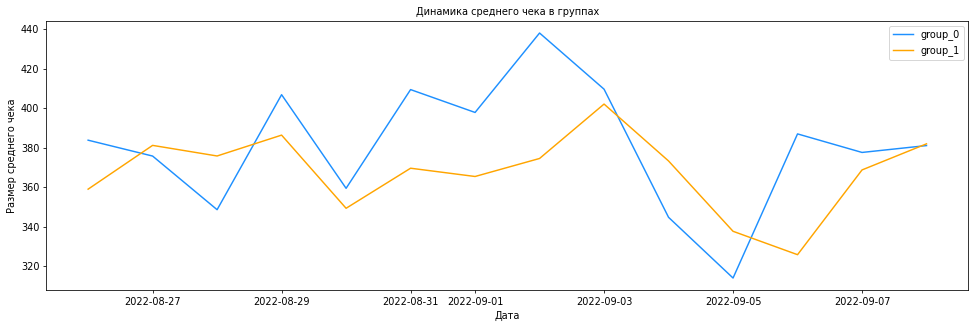

In [106]:
plt.figure(figsize=(17,5), dpi= 70)
sns.lineplot(data=avg_check_day_control,x='date',y='avg_check',color="dodgerblue",label="group_0")
sns.lineplot(data=avg_check_day_test,x='date',y='avg_check',color="orange",label="group_1")

plt.title('Динамика среднего чека в группах', fontsize=10)
plt.xlabel("Дата")
plt.ylabel("Размер среднего чека")
plt.legend()
plt.show()

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1311855383.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(avg_check_day_control.avg_check, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1311855383.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

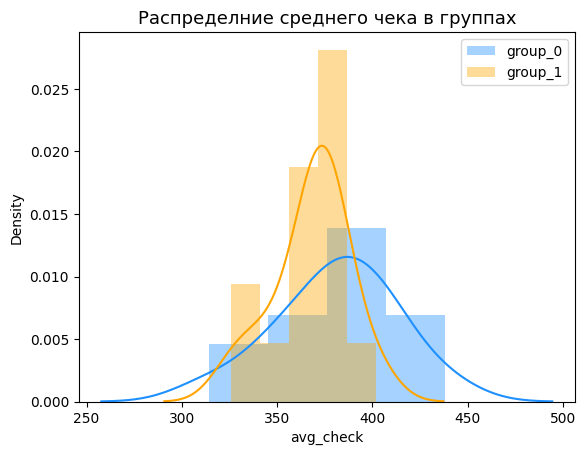

In [107]:
#Распределение метрики среднего чека в группах

sns.distplot(avg_check_day_control.avg_check, color="dodgerblue", label="group_0",kde=True)
sns.distplot(avg_check_day_test.avg_check, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние среднего чека в группах', fontsize=13)
plt.legend()
plt.show()

**В обоих группах распределение метрики - средний чек - нормальное**

#### Анализ метрики - средний чек - на стат значимые различия

In [108]:
#Среднее значение среднего чека в группах 

print(f'Значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ {round(avg_check_day_control.avg_check.mean(),2)}')
print()
print(f'Значение среднего чека в ТЕСТОВОЙ ГРУППЕ {round(avg_check_day_test.avg_check.mean(),2)}')

Значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ 381.01

Значение среднего чека в ТЕСТОВОЙ ГРУППЕ 367.96


In [109]:
#Медианное значение среднего чека в группах 

print(f'Медианное значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ {round(avg_check_day_control.avg_check.median(),2)}')
print()
print(f'Медианное значение среднего чека в ТЕСТОВОЙ ГРУППЕ {round(avg_check_day_test.avg_check.median(),2)}')

Медианное значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ 382.46

Медианное значение среднего чека в ТЕСТОВОЙ ГРУППЕ 371.49


Получается, что среднее значение и медианное значение среднего чека в группе со старым алгоритмом больше, чем в группе с новым алгоритмом. Нужно теперь понять эти различия статистически значимы или нет. 

Как я уже ранее посмотрела, распределение среднего чека в обоих группах нормальное, нет выбросов. Но нужно проверить эти выборки на нормальность. 

#### Сформулируем гипотезы, которые буду проверять в этом эксперименте

1. **Нулевая гипотеза (H0): Разницы между значением среднего чека в тестовой и контрольной группе нет**
---------
2. **Альтернативная гипотеза (H1): Разница между значением среднего чека в тестовой и контрольной группе есть**

*Первое, что я сделаю - это изучу распределения. Проверю выполнение условий на нормальность*

In [110]:
#берём данные нужной нам группы - это контрольная группа, группа со старым алгоритмом и кладём в функцию

_,p = stats.normaltest(avg_check_day_control.avg_check)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в выборке распределены нормально p-value:{p}')

Значения в выборке распределены нормально p-value:0.6913657184753919


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  k, _ = kurtosistest(a, axis)


In [111]:
#берём данные нужной нам группы - это тестовая группа, группа с новым алгоритмом и кладём в функцию

_,p = stats.normaltest(avg_check_day_test.avg_check)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в выборке распределены нормально p-value:{p}')

Значения в выборке распределены нормально p-value:0.4092522532846271


##### Визуализирую распределение у группах 

Text(0.5, 1.0, 'Распределние среднего чека в тестовой группе')

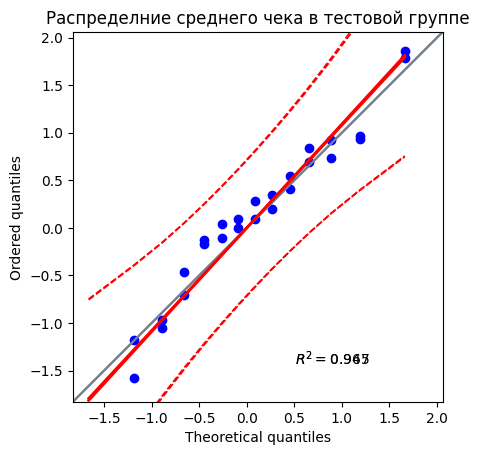

In [112]:
#Распределение среднего чека в группах
pg.qqplot(avg_check_day_control.avg_check, dist='norm')
plt.title("Распределние среднего чека в контрольной группе")


pg.qqplot(avg_check_day_test.avg_check, dist='norm')
plt.title("Распределние среднего чека в тестовой группе")

#### Вывод: 

Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона по функции scipy.stats.normaltest(). Этот тест показывает, что значения в тестовой группе распределены НОРМАЛЬНО(pvalue = 0.691). В контрольной группе распределение является НОРМАЛЬНЫМ (pvalue=0.409).

Я склоняюсь к применению параметрического теста в этом эксперименте, но еще нужно проверить гомогенность дисперсий. Это можно сделать  с помощью критерия Левена.  

In [113]:
#Проверка на гомогенность дисперсий с помощью критерия Левена.

_, p = stats.levene(avg_check_day_test.avg_check, avg_check_day_control.avg_check)
if p > 0.05:
    print('Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.')
else:
    print('Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается')

Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.


Вывод: 

Чтобы применить Т-тест, я должна была проверить: 
1. Гомогенность дисперсий,
2. Нормальность распределения. 


Итог, я могу применить t-тест. Потому что распределение в выборке нормальное, и соблюдается требование о гомогенности дисперсий. 

##### Применяю t-тест - > сравниваю метрику среднее  значение среднего чека в группах

In [114]:
#Для сравнения средних в данных экспериментальных группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(avg_check_day_test.avg_check, avg_check_day_control.avg_check)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Получили статистически значимые различия. Нулевая гипотеза отклоняется')


Не получили статистически значимых различий. Альтернативная гипотеза отклоняется


#### Вывод

В ходе этого эксперимента я не получила статистически значимых различий между метрикой среднего чека в группе со старым и с новым алгоритмом. Я поняла, что, возможно, из-за небольшого размера выборки у меня не получилось задетектировать стат значимые различия. Попробую взять метрику средний чек по по пользователю. 

### 2.1 Средний чек пользователя

Напомню, что в табл **test_orders** находится дф с данными группы, которая пользуется системой рекомендации, а **control_orders** группа пользователей, у которой нет системы рекомендаций.


In [115]:
#Посчитаю метрику средний чек по пользователю каждой группы

group_1_avg = test_orders.groupby('user_id',as_index=False).agg({'total_price':'mean'}) \
        .rename(columns={'total_price':'avg_check'})


group_0_avg = control_orders.groupby('user_id',as_index=False).agg({'total_price':'mean'}) \
        .rename(columns={'total_price':'avg_check'})

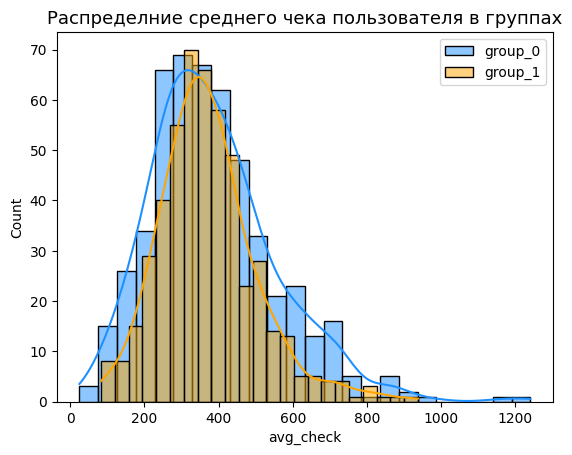

In [116]:
#Распределние среднего чека пользователя в группах
sns.histplot(group_0_avg.avg_check, color="dodgerblue", label="group_0",kde=True)
sns.histplot(group_1_avg.avg_check, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние среднего чека пользователя в группах', fontsize=13)
plt.legend()
plt.show()


Распределние не похоже на нормальное. Обычно при таких вводных используют непараметрику, но насколько мне известно, что т-тест можно использовать.

In [117]:
#Среднее значение среднего чека в группах 

print(f'Значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ {round(group_0_avg.avg_check.mean(),2)}')
print()
print(f'Значение среднего чека в ТЕСТОВОЙ ГРУППЕ {round(group_1_avg.avg_check.mean(),2)}')

Значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ 386.04

Значение среднего чека в ТЕСТОВОЙ ГРУППЕ 371.2


In [118]:
group_0_avg.avg_check.mean() - group_1_avg.avg_check.mean()

14.835430955449226

In [119]:
#Медианное значение среднего чека в группах 

print(f'Медианное значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ {round(group_0_avg.avg_check.median(),2)}')
print()
print(f'Медианное значение среднего чека в ТЕСТОВОЙ ГРУППЕ {round(group_1_avg.avg_check.median(),2)}')

Медианное значение среднего чека в КОНТРОЛЬНОЙ ГРУППЕ 362.67

Медианное значение среднего чека в ТЕСТОВОЙ ГРУППЕ 355.92


In [120]:
group_0_avg.avg_check.median() - group_1_avg.avg_check.median()

6.741666666666617

Я посмотрела на среднее и медианное значения среднего чека пользователя, получается, что значение среднего чека в тестовой группе меньше в медианном значении на 7 рублей(если округлить), в среднем значении на 15 рублей(если округлить). Сейчас я проверю стат значимы эти различия или это случайные колебания. 

#### Применяю STUDENT'S T-TEST - > сравниваю метрику среднее  значение среднего чека пользователя в группах

In [121]:
#Для сравнения метрики в экспериментальной и контрольной группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(group_1_avg.avg_check,group_0_avg.avg_check)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Нулевая гипотеза отклоняется. Получили стат значимые различия')

Не получили статистически значимых различий. Альтернативная гипотеза отклоняется


_____

## 3. Метрика - Количество активных пользователей(DAU)

Активные пользователи - это те пользователи, которые совершили хотя бы один заказ. 

In [122]:
#Подготовлю дф. Нужно убрать отмененные заказы. 

#1 Выделила order_id отмененных заказов в отдельный лист для удобной фильтрации
list_cancel_order = ab_users_data.query('action == "cancel_order"')['order_id'].to_list()

#2 Применила фильтр, убрала отмененные заказы
df_create_orders = ab_users_data.query('order_id not in @list_cancel_orders')

In [123]:
#Посчитаю кол-во активных пользователей в день в тестовой группе 

test_active_user = df_create_orders.query('group==1') \
        .groupby(['date','user_id'],as_index=False).agg({'order_id':'nunique'}) \
        .rename(columns={'order_id':'count_orders'}).query('count_orders>=1')

#Посчитаю метрику кол-во активных юзеров - DAU в тестовой группе 
test_DAU = test_active_user.groupby('date',as_index=False).agg({'user_id':'count'}) \
        .rename(columns={'user_id':'DAU'})

In [124]:
#Посчитаю кол-во активных пользователей в день в контрольной группе 

control_active_user = df_create_orders.query('group==0') \
        .groupby(['date','user_id'],as_index=False).agg({'order_id':'nunique'}) \
        .rename(columns={'order_id':'count_orders'}).query('count_orders>=1')

#Посчитаю метрику кол-во активных юзеров - DAU в тестовой группе 
control_DAU = control_active_user.groupby('date',as_index=False).agg({'user_id':'count'}) \
        .rename(columns={'user_id':'DAU'})

##### Визуализация метрики - DAU (Daily Active Users) в группах 

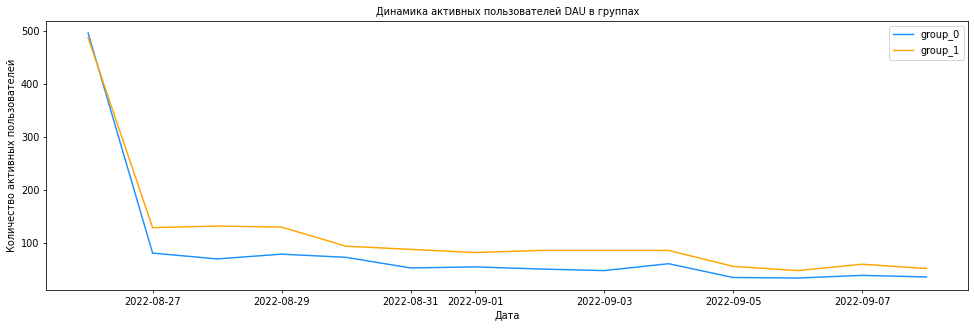

In [125]:
#Визуализация Динмамика DAU в группах
plt.figure(figsize=(17,5), dpi= 70)
sns.lineplot(data=control_DAU,x='date',y='DAU',color="dodgerblue",label="group_0")
sns.lineplot(data=test_DAU,x='date',y='DAU',color="orange",label="group_1")

plt.title('Динамика активных пользователей DAU в группах', fontsize=10)
plt.xlabel("Дата")
plt.ylabel("Количество активных пользователей")
plt.legend()
plt.show()

##### Визуализация распределения DAU в группах 

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1617921254.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(control_DAU.DAU, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1617921254.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

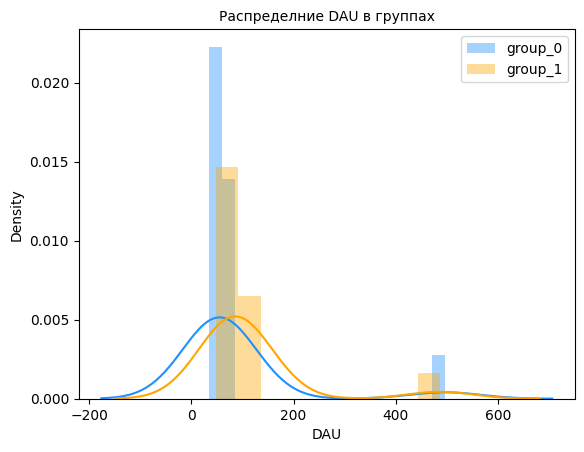

In [126]:
#Распределение DAU в группах
sns.distplot(control_DAU.DAU, color="dodgerblue", label="group_0",kde=True)
sns.distplot(test_DAU.DAU, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние DAU в группах', fontsize=10)
plt.legend()
plt.show()

Итог.У нас в обеих группах наблюдается выброс. От выброса можно избавиться двумя вариантами: либо логарифм, либо фильтрация. Воспользуюсь вторым вариантом. 

In [127]:
#Логарифм не помог избавиться от выброса, поэтому сделаю фильтрацию. date !="2022-08-26". В этот день наблюдается выброс

control_DAU_t = control_DAU.query('date !="2022-08-26"')
test_DAU_t = test_DAU.query('date !="2022-08-26"')

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/2838957172.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(control_DAU_t.DAU, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/2838957172.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

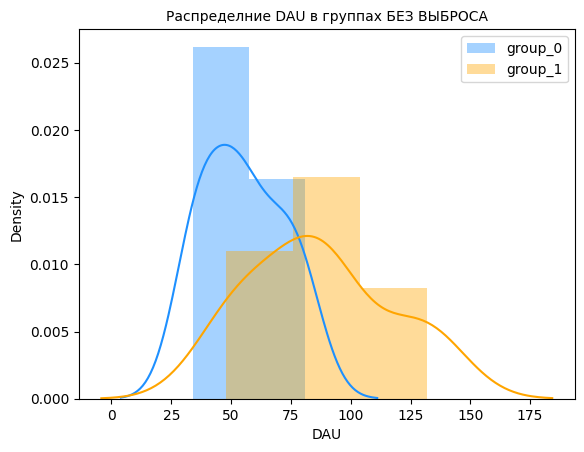

In [128]:
#Распределение DAU в группах БЕЗ ВЫБРОСА

sns.distplot(control_DAU_t.DAU, color="dodgerblue", label="group_0",kde=True)
sns.distplot(test_DAU_t.DAU, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние DAU в группах БЕЗ ВЫБРОСА', fontsize=10)
plt.legend()
plt.show()

In [129]:
#Среднее значение DAU в группах с выбросом

print(f'Среднее значение DAU в КОНТРОЛЬНОЙ ГРУППЕ {round(control_DAU.DAU.mean(),2)}')
print()
print(f'Среднее значение DAU в ТЕСТОВОЙ ГРУППЕ {round(test_DAU.DAU.mean(),2)}')

Среднее значение DAU в КОНТРОЛЬНОЙ ГРУППЕ 86.5

Среднее значение DAU в ТЕСТОВОЙ ГРУППЕ 115.43


In [130]:
#Среднее значение DAU в группах БЕЗ ВЫБРОСА

print(f'Среднее значение DAU в КОНТРОЛЬНОЙ ГРУППЕ {round(control_DAU_t.DAU.mean(),2)}')
print()
print(f'Среднее значение DAU в ТЕСТОВОЙ ГРУППЕ {round(test_DAU_t.DAU.mean(),2)}')

Среднее значение DAU в КОНТРОЛЬНОЙ ГРУППЕ 55.0

Среднее значение DAU в ТЕСТОВОЙ ГРУППЕ 86.85


In [131]:
#Разница между средним значением DAU 
diff = test_DAU_t.DAU.mean() - control_DAU_t.DAU.mean()
print(f'''Есть разница между средним значением DAU в группах. В тестовой группе среднее значение активных пользователей больше чем в тестовой 
на {round(diff,2)}''')

Есть разница между средним значением DAU в группах. В тестовой группе среднее значение активных пользователей больше чем в тестовой 
на 31.85


Проверю гипотезу с помощью статистического теста. Есть две количественные переменные.

#### Гипотезы, которые буду проверять в этом эксперименте:

1. **Нулевая гипотеза (H0): Разницы между значением DAU в тестовой и контрольной группе нет**
---------
2. **Альтернативная гипотеза (H1): Разница между значением DAU в тестовой и контрольной группе есть**

*1. Нужно проверить нормальность распределения*

In [132]:
#берём данные нужной нам группы - это контрольная группа, группа со старым алгоритмом и кладём в функцию БЕЗ ВЫБРОСОВ

_,p = stats.normaltest(control_DAU_t.DAU)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в выборке распределены нормально p-value:{p}')

Значения в выборке распределены нормально p-value:0.3497918100474452


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  k, _ = kurtosistest(a, axis)


In [133]:
#берём данные нужной нам группы - это тестовая группа, группа со старым алгоритмом и кладём в функцию БЕЗ ВЫБРОСОВ

_,p = stats.normaltest(test_DAU_t.DAU)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в выборке распределены нормально p-value:{p}')

Значения в выборке распределены нормально p-value:0.6225848194154309


*2. Гомогенность дисперсий*

In [134]:
#Проверка на гомогенность дисперсий с помощью критерия Левена.

_, p = stats.levene(test_DAU_t.DAU, control_DAU_t.DAU)
if p > 0.05:
    print('Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.')
else:
    print('Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается')

Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.


Итог, я могу применить t-тест. Потому что распределение в выборке нормальное, и соблюдается требование о гомогенности дисперсий.

#### Применяю t-тест - > сравниваю метрику DAU в группах

In [135]:
#Для сравнения DAU в данных экспериментальных группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(test_DAU_t.DAU, control_DAU_t.DAU)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Получили статистически значимые различия. Нулевая гипотеза отклоняется')

Получили статистически значимые различия. Нулевая гипотеза отклоняется


### Вывод: 
Результат оказался статистически ЗНАЧИМ. Значит, в тестовой группе увеличилось количество активных пользователей. 

## 4. Метрика - Количество товаров в заказах

Увеличилось ли кол-во товаров в корзинах пользователей. 

In [136]:
#Подготовим данные. Нужно объединить два дф: история заказов и информация о составе заказа. 

#1 Выделила order_id отмененных заказов в отдельный лист для удобной фильтрации
list_cancel_order = ab_users_data.query('action == "cancel_order"')['order_id'].to_list()

#2 Применила фильтр, убрала отмененные заказы
orders_df = ab_users_data.query('order_id not in @list_cancel_orders')

In [137]:
#Объединила отфильтрованный дф с информацией о заказах
basket_users = orders_df.merge(ab_orders,on='order_id')

#Преобразую колонку product_ids в лист, чтобы посчитать кол-во товаров
basket_users['product_ids'] = basket_users['product_ids'] \
        .apply(lambda i: i.replace('{','').replace('}','').replace('{','').split(', '))

basket_users = basket_users.explode('product_ids', ignore_index=False)

basket_users = basket_users.astype({'product_ids':'int64'})

In [138]:
basket_users.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56


In [139]:
#Выделю группы в отдельный дф 
basket_users_control = basket_users.query('group == 0')
basket_users_test = basket_users.query('group == 1')

**Считаю метрику - количество товаров в заказах**

In [140]:
#Подсчет кол-ва товаров в коризне пользователя в контрольной группе 
groupby_control = basket_users_control.groupby(['order_id','user_id'],as_index=False).agg({'product_ids':'count'})
number_of_products_0 = groupby_control.groupby('user_id',as_index=False).agg({'product_ids':'sum'}) \
        .rename(columns={'product_ids':'counts'})

In [141]:
number_of_products_0.counts.mean()

9.966796875

In [142]:
#Подсчет кол-ва товаров в корзине пользователя в тестовой группе 
groupby_test = basket_users_test.groupby(['order_id','user_id'],as_index=False).agg({'product_ids':'count'})
number_of_products_1 = groupby_test.groupby('user_id',as_index=False).agg({'product_ids':'sum'}) \
        .rename(columns={'product_ids':'counts'})

In [143]:
number_of_products_1.counts.mean()

15.928143712574851

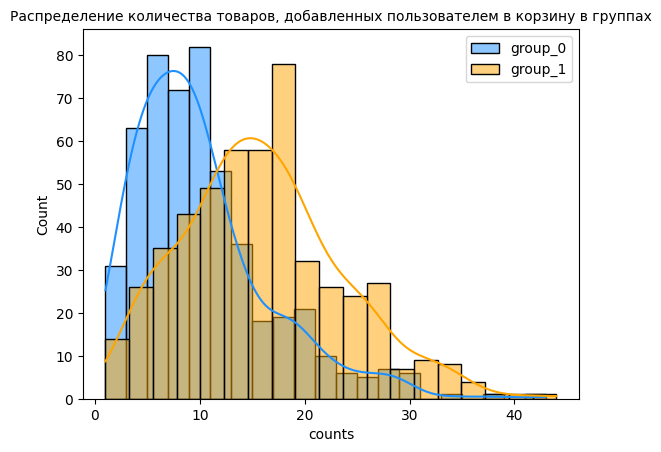

In [144]:
#Визуализация распределения
sns.histplot(number_of_products_0.counts, color="dodgerblue", label="group_0",kde=True)
sns.histplot(number_of_products_1.counts, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределение количества товаров, добавленных пользователем в корзину в группах', fontsize=10)
plt.legend()
plt.show()

In [145]:
print(f'Среднее значение метрики в КОНТРОЛЬНОЙ ГРУППЕ {round(number_of_products_0.counts.mean(),2)}')
print()
print(f'Среднее значение метрики в ТЕСТОВОЙ ГРУППЕ {round(number_of_products_1.counts.mean(),2)}')

Среднее значение метрики в КОНТРОЛЬНОЙ ГРУППЕ 9.97

Среднее значение метрики в ТЕСТОВОЙ ГРУППЕ 15.93


Проверю гипотезу с помощью статистического теста. Есть две количественные переменные.

#### Гипотезы, которые буду проверять в этом эксперименте:
1. Нулевая гипотеза (H0): Разницы между значением  кол-ва товаров в корзине в тестовой и контрольной группе нет
2. Альтернативная гипотеза (H1): Разница между значением кол-ва товаров в корзине в тестовой и контрольной группе есть

*1. Нужно проверить нормальность распределения*

In [146]:
#берём данные нужной нам группы - это контрольная группа, группа со старым алгоритмом и кладём в функцию БЕЗ ВЫБРОСОВ

_,p = stats.normaltest(number_of_products_0.counts)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value: {p}')
else:
    print(f'Значения в выборке распределены нормально p-value: {p}')

Значения в выборке распределены ненормально p-value: 1.9830884485278113e-29


In [147]:
#берём данные нужной нам группы - это тестовая группа, группа со старым алгоритмом и кладём в функцию 
_,p = stats.normaltest(number_of_products_1.counts)
if p < 0.05:
    print(f'Значения в выборке распределены ненормально p-value: {p}')
else:
    print(f'Значения в выборке распределены нормально p-value: {p}')

Значения в выборке распределены ненормально p-value: 7.832071135244121e-05


*2. Гомогенность дисперсий*

In [148]:
_,p = stats.levene(number_of_products_1.counts,number_of_products_0.counts)
if p > 0.05:
    print('Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.')
else:
    print('Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается')

Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается


Распределение не является нормальным, также дисперсии в группах различны, обычно при таких вводных используют непараметрику, но насколько мне известно из лекций, что т-тест можно использовать.

In [150]:
#Для сравнения метрики в экспериментальной и контрольной группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(number_of_products_1.counts,number_of_products_0.counts)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Нулевая гипотеза отклоняется. Получили стат значимые различия')

Нулевая гипотеза отклоняется. Получили стат значимые различия


#### Вывод: 
Результат оказался статистически ЗНАЧИМ. Значит, в тестовой группе, где пользовати пользуются приложением с системой рекомендаций товаров пользователи больше товаров добавляют в коризну.
____

### 5. Метрика - кол-во созданных заказов - увеличилось ли кол-во заказов 

In [151]:
#Подготовлю дф. Нужно убрать отмененные заказы. 

#1 Выделила order_id отмененных заказов в отдельный лист для удобной фильтрации
list_cancel_order = ab_users_data.query('action == "cancel_order"')['order_id'].to_list()

#2 Применила фильтр, убрала отмененные заказы
df_create_orders = ab_users_data.query('order_id not in @list_cancel_orders')

In [152]:
#Выделю в отдельный дф кол-во созданных заказов в тестовой и контрольной группе 
create_order_control = df_create_orders.query('group==0') \
        .groupby('date',as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders_control'})

create_order_test = df_create_orders.query('group==1') \
        .groupby('date',as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders_test'})

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1270933522.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(create_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1270933522.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

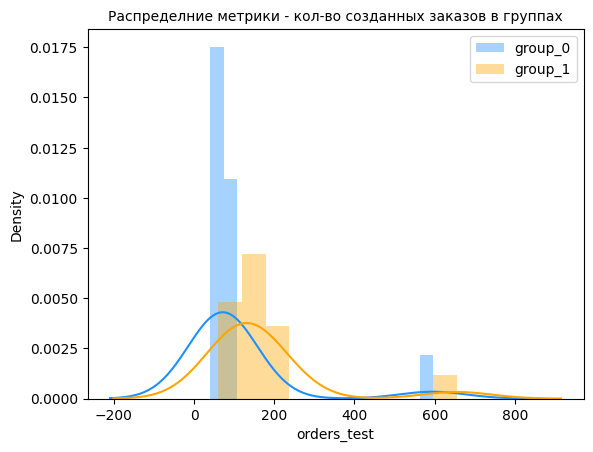

In [153]:
#Распределение метрики созданных заказов в группах

sns.distplot(create_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
sns.distplot(create_order_test.orders_test, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние метрики - кол-во созданных заказов в группах', fontsize=10)
plt.legend()
plt.show()

In [154]:
#Уберем выбросы за 2022-08-26
df_create_order_control = create_order_control.query('date != "2022-08-26"')
df_create_order_test = create_order_test.query('date != "2022-08-26"')

/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1108867550.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_create_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
/var/folders/4j/vmcpdtvd4639j98wbjhbvtdm0000gp/T/ipykernel_66593/1108867550.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

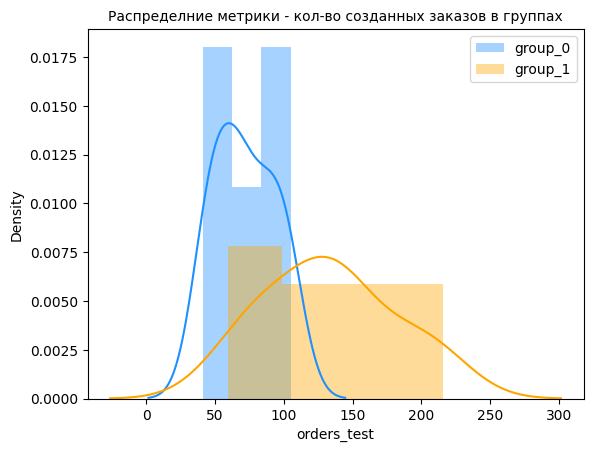

In [155]:
#Распределение метрики созданных заказов в группах

sns.distplot(df_create_order_control.orders_control, color="dodgerblue", label="group_0",kde=True)
sns.distplot(df_create_order_test.orders_test, color="orange", label="group_1",kde=True)

# Decoration
plt.title('Распределние метрики - кол-во созданных заказов в группах', fontsize=10)
plt.legend()
plt.show()

#### Анализ метрики - кол-во созданных заказов - на стат значимые различия

In [156]:
#Среднее кол-во отмененных заказов в группах

print(f'Среднее кол-во созданных заказов в контрольной группе(0): {round(create_order_control.orders_control.mean(),2)}')
print()
print(f'Среднее кол-во созданных заказов в тестовой группе(1): {round(create_order_test.orders_test.mean().mean(),2)}')

Среднее кол-во созданных заказов в контрольной группе(0): 109.07

Среднее кол-во созданных заказов в тестовой группе(1): 170.14


#### Сформулирую гипотезы, которые буду проверять в этом эксперименте
---
**1. Нулевая гипотеза (H0): Разницы между средним значением кол-ва созданных заказов в тестовой и контрольной группе нет**

**2. Альтернативная гипотеза (H1): Разница между средним значением кол-ва созданных заказов  в тестовой и контрольной группе есть**

Выше я вывела два варианта распределения анализируемой метрики. Есть выборка с ненормальным распределением, там есть выброс за 2022-08-26. Я буду использовать параметрику - т-тест. 

In [158]:
#Для сравнения метрики в экспериментальной и контрольной группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(df_create_order_control.orders_control, df_create_order_test.orders_test)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Нулевая гипотеза отклоняется. Получили стат значимые различия')

Нулевая гипотеза отклоняется. Получили стат значимые различия


### Вывод:

В группе, которая пользуется приложением с новой системой рекомендаций за исследуемый период увеличилось кол-во созданных заказов. Пользователи в тестовой группе создали на (в среднем) на 61 заказ больше, по сравнению с контрольной группой. По данным этого эксперимента. 

# Итоговый вывод: 

Я выделила 5 метрик для оценки качества работы новой системы рекомендаций. 

1. Количество отмененных заказов
2. Средний чек
3. Количество активных пользователей(DAU)
4. Среднее кол-во товаров в заказах
5. Кол-во созданных заказов

Статистический анализ метрик показал, что в группе пользователей с новой системой рекомендаций -  статистически увеличилось количество активных юзеров, они стали больше создавать заказов, больше добавлять товаров в корзину, но вместе с этими показателями и статистически значимо увеличилось количество отмененных заказов в этой группе. Что логично. 

Также я анализировала метрику средний чек в группах. Анализ не дал статистически значимых различий. По моей логике, при росте числа заказов, средний чек пользователя должен вырасти, но получается, что средний чек не вырос. Поэтому, думаю, что не стоит выкатывать новый алгоритм. 
Но! Закралось сомнение. 